In [2]:
# Notebook cell: Compute JS and Cosine distances

import json, os, math
import numpy as np
import pandas as pd
from typing import Dict, Tuple, List

DATA_DIR = "data/Squad"
FILES = {
    "teacher": "llama-70B-teacher.jsonl",
    "deepseek_student": "deepseek-distill-student.jsonl",
    "mistral_control": "mistral-7B-control.jsonl",
}

def read_jsonl(path: str) -> Dict[str, Dict]:
    out = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            rec = json.loads(line)
            out[rec["id"]] = rec
    return out

def union_distribution(rec_a: Dict, rec_b: Dict, eps: float = 1e-12) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    la = rec_a["logprobs_top5"]
    lb = rec_b["logprobs_top5"]
    toks = sorted(set(la.keys()) | set(lb.keys()))
    pa = np.array([math.exp(la[t]) if t in la else 0.0 for t in toks], dtype=float)
    pb = np.array([math.exp(lb[t]) if t in lb else 0.0 for t in toks], dtype=float)
    pa = pa + eps
    pb = pb + eps
    pa = pa / pa.sum()
    pb = pb / pb.sum()
    return pa, pb, toks

def js_divergence_base2(p: np.ndarray, q: np.ndarray) -> float:
    m = 0.5 * (p + q)
    def _kl(a, b):
        return float(np.sum(a * (np.log2(a) - np.log2(b))))
    return 0.5 * _kl(p, m) + 0.5 * _kl(q, m)

def cosine_similarity(p: np.ndarray, q: np.ndarray) -> float:
    denom = (np.linalg.norm(p) * np.linalg.norm(q))
    if denom == 0:
        return 0.0
    return float(np.dot(p, q) / denom)

# Load files
loaded = {k: read_jsonl(os.path.join(DATA_DIR, v)) for k, v in FILES.items()}

# Common IDs
common_ids = sorted(list(
    set(loaded["teacher"]) &
    set(loaded["deepseek_student"]) &
    set(loaded["mistral_control"])
))
if not common_ids:
    raise RuntimeError("No overlapping IDs found.")

# Compute distances
rows = []
for pid in common_ids:
    t = loaded["teacher"][pid]
    d = loaded["deepseek_student"][pid]
    m = loaded["mistral_control"][pid]

    p_td, q_td, _ = union_distribution(t, d)
    jsdist_td = math.sqrt(js_divergence_base2(p_td, q_td))
    cosdist_td = 1.0 - cosine_similarity(p_td, q_td)

    p_tm, q_tm, _ = union_distribution(t, m)
    jsdist_tm = math.sqrt(js_divergence_base2(p_tm, q_tm))
    cosdist_tm = 1.0 - cosine_similarity(p_tm, q_tm)

    rows.append({
        "id": pid,
        "masked_sentence": t.get("masked_sentence", ""),
        "JS_distance_teacher_vs_deepseek": jsdist_td,
        "Cosine_distance_teacher_vs_deepseek": cosdist_td,
        "JS_distance_teacher_vs_mistral": jsdist_tm,
        "Cosine_distance_teacher_vs_mistral": cosdist_tm,
    })

df = pd.DataFrame(rows)

# Summary
summary = pd.DataFrame({
    "pair": ["teacher_vs_deepseek", "teacher_vs_mistral"],
    "mean_JS_distance": [
        df["JS_distance_teacher_vs_deepseek"].mean(),
        df["JS_distance_teacher_vs_mistral"].mean()
    ],
    "median_JS_distance": [
        df["JS_distance_teacher_vs_deepseek"].median(),
        df["JS_distance_teacher_vs_mistral"].median()
    ],
    "mean_Cosine_distance": [
        df["Cosine_distance_teacher_vs_deepseek"].mean(),
        df["Cosine_distance_teacher_vs_mistral"].mean()
    ],
    "median_Cosine_distance": [
        df["Cosine_distance_teacher_vs_deepseek"].median(),
        df["Cosine_distance_teacher_vs_mistral"].median()
    ],
    "n_prompts": [len(df), len(df)]
})

# Save
df.to_csv("squad_model_distances.csv", index=False)
summary.to_csv("squad_distance_summary.csv", index=False)

print("Per-prompt distances:\n", df.head(), "\n")
print("Summary:\n", summary)

Per-prompt distances:
                            id  \
0  56bf41013aeaaa14008c959b_0   
1  56bf57043aeaaa14008c95da_0   
2  56d709ef0d65d21400198306_0   
3  56d724ea0d65d214001983c8_0   
4  56d7277c0d65d21400198402_0   

                                     masked_sentence  \
0      The first choice in the NFL draft of 1998 was   
1        The Media Day for Super Bowl 50 was held on   
2    The Panthers head coach for the 2015 season was   
3       the Super Bowl in England will be carried by   
4  Gary Kubiak partedipated in the Super Bowl, as...   

   JS_distance_teacher_vs_deepseek  Cosine_distance_teacher_vs_deepseek  \
0                         0.399644                             0.036513   
1                         0.628527                             0.206984   
2                         1.000000                             1.000000   
3                         0.534646                             0.270193   
4                         0.621817                             0.2

In [3]:
import pandas as pd
from scipy import stats

# Load the per-prompt distances
df = pd.read_csv("squad_model_distances.csv")

# Paired differences
js_diff = df["JS_distance_teacher_vs_mistral"] - df["JS_distance_teacher_vs_deepseek"]
cos_diff = df["Cosine_distance_teacher_vs_mistral"] - df["Cosine_distance_teacher_vs_deepseek"]

# Paired t-tests
t_js, p_js = stats.ttest_rel(
    df["JS_distance_teacher_vs_mistral"],
    df["JS_distance_teacher_vs_deepseek"]
)
t_cos, p_cos = stats.ttest_rel(
    df["Cosine_distance_teacher_vs_mistral"],
    df["Cosine_distance_teacher_vs_deepseek"]
)

# Wilcoxon signed-rank (nonparametric alternative)
w_js, wp_js = stats.wilcoxon(
    df["JS_distance_teacher_vs_mistral"],
    df["JS_distance_teacher_vs_deepseek"]
)
w_cos, wp_cos = stats.wilcoxon(
    df["Cosine_distance_teacher_vs_mistral"],
    df["Cosine_distance_teacher_vs_deepseek"]
)

print("Paired t-test (JS):     t = %.3f, p = %.3e" % (t_js, p_js))
print("Paired t-test (Cosine): t = %.3f, p = %.3e" % (t_cos, p_cos))
print("Wilcoxon (JS):          W = %.3f, p = %.3e" % (w_js, wp_js))
print("Wilcoxon (Cosine):      W = %.3f, p = %.3e" % (w_cos, wp_cos))


Paired t-test (JS):     t = 27.275, p = 2.873e-71
Paired t-test (Cosine): t = 28.391, p = 3.599e-74
Wilcoxon (JS):          W = 43.000, p = 1.950e-36
Wilcoxon (Cosine):      W = 47.000, p = 2.063e-36


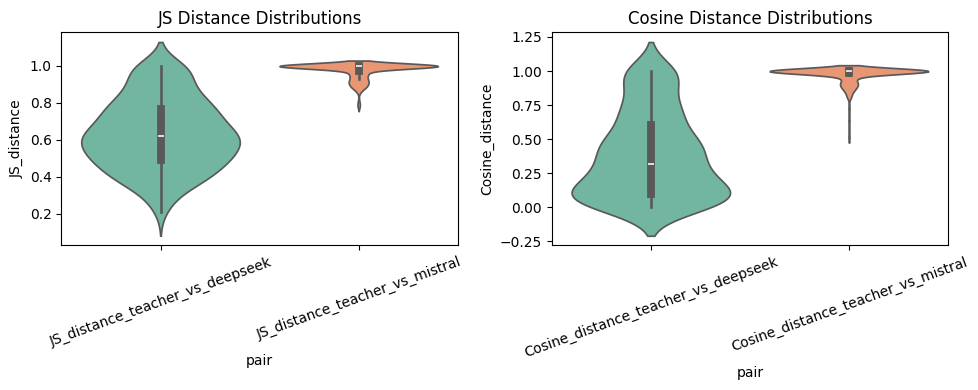

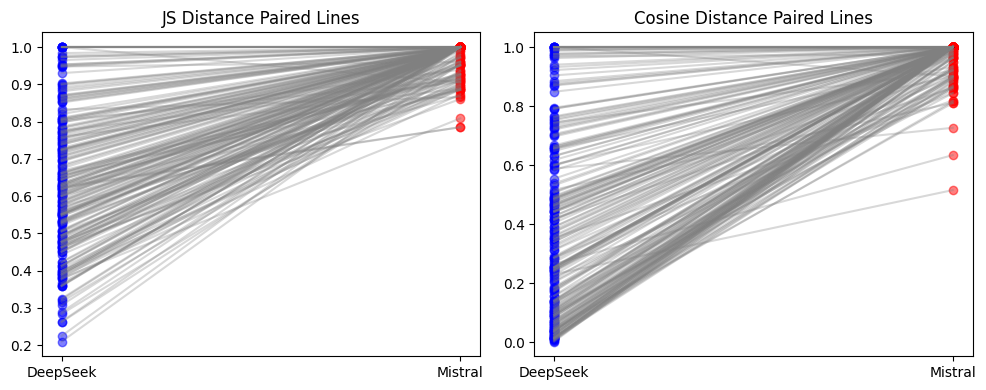

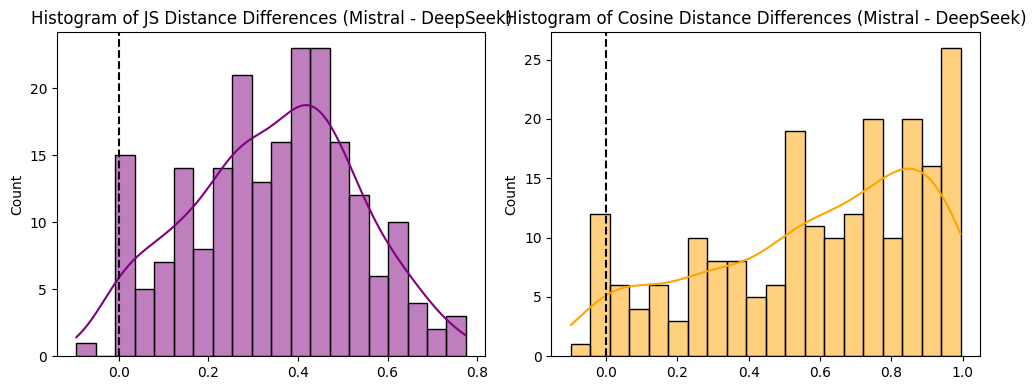

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("squad_model_distances.csv")

# Melt for easier plotting
df_melt_js = df.melt(id_vars=["id"], 
                     value_vars=["JS_distance_teacher_vs_deepseek", "JS_distance_teacher_vs_mistral"],
                     var_name="pair", value_name="JS_distance")
df_melt_cos = df.melt(id_vars=["id"], 
                      value_vars=["Cosine_distance_teacher_vs_deepseek", "Cosine_distance_teacher_vs_mistral"],
                      var_name="pair", value_name="Cosine_distance")

# 1. Box/violin plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
# sns.violinplot(data=df_melt_js, x="pair", y="JS_distance", inner="box", palette="Set2")
sns.violinplot(
    data=df_melt_js, 
    x="pair", y="JS_distance", hue="pair",
    inner="box", palette="Set2", legend=False
)
plt.title("JS Distance Distributions")
plt.xticks(rotation=20)

plt.subplot(1,2,2)
# sns.violinplot(data=df_melt_cos, x="pair", y="Cosine_distance", inner="box", palette="Set2")
sns.violinplot(
    data=df_melt_cos, 
    x="pair", y="Cosine_distance", hue="pair",
    inner="box", palette="Set2", legend=False
)
plt.title("Cosine Distance Distributions")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# 2. Paired line plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for _, row in df.iterrows():
    plt.plot(["DeepSeek", "Mistral"], 
             [row["JS_distance_teacher_vs_deepseek"], row["JS_distance_teacher_vs_mistral"]],
             color="gray", alpha=0.3)
plt.scatter(["DeepSeek"]*len(df), df["JS_distance_teacher_vs_deepseek"], color="blue", alpha=0.5)
plt.scatter(["Mistral"]*len(df), df["JS_distance_teacher_vs_mistral"], color="red", alpha=0.5)
plt.title("JS Distance Paired Lines")

plt.subplot(1,2,2)
for _, row in df.iterrows():
    plt.plot(["DeepSeek", "Mistral"], 
             [row["Cosine_distance_teacher_vs_deepseek"], row["Cosine_distance_teacher_vs_mistral"]],
             color="gray", alpha=0.3)
plt.scatter(["DeepSeek"]*len(df), df["Cosine_distance_teacher_vs_deepseek"], color="blue", alpha=0.5)
plt.scatter(["Mistral"]*len(df), df["Cosine_distance_teacher_vs_mistral"], color="red", alpha=0.5)
plt.title("Cosine Distance Paired Lines")
plt.tight_layout()
plt.show()

# 3. Histogram of differences
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
diff_js = df["JS_distance_teacher_vs_mistral"] - df["JS_distance_teacher_vs_deepseek"]
sns.histplot(diff_js, bins=20, kde=True, color="purple")
plt.axvline(0, color="black", linestyle="--")
plt.title("Histogram of JS Distance Differences (Mistral - DeepSeek)")

plt.subplot(1,2,2)
diff_cos = df["Cosine_distance_teacher_vs_mistral"] - df["Cosine_distance_teacher_vs_deepseek"]
sns.histplot(diff_cos, bins=20, kde=True, color="orange")
plt.axvline(0, color="black", linestyle="--")
plt.title("Histogram of Cosine Distance Differences (Mistral - DeepSeek)")

plt.tight_layout()
plt.show()


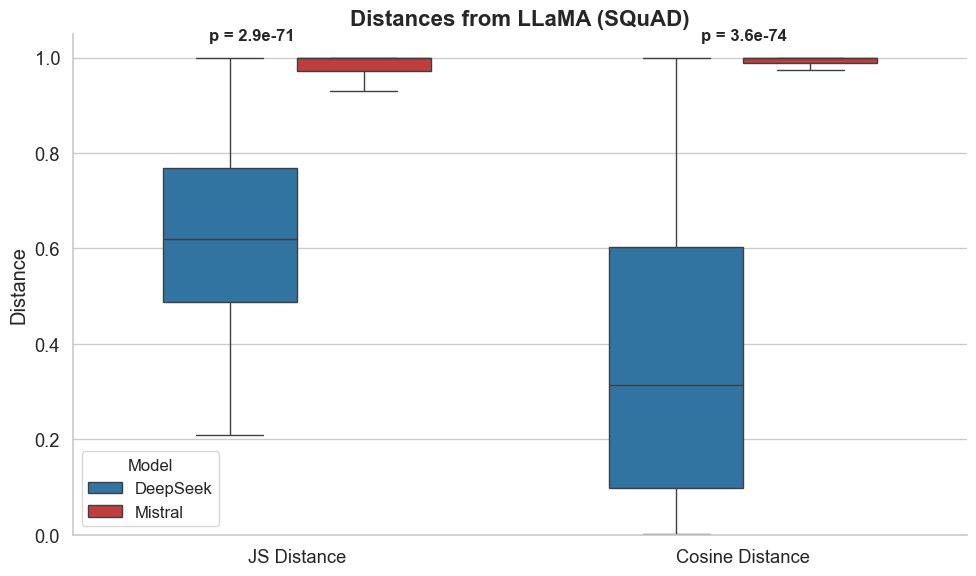

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Load distances
df = pd.read_csv("squad_model_distances.csv")

# Prepare data
df_js = pd.DataFrame({
    "Distance": df["JS_distance_teacher_vs_deepseek"].tolist() +
                df["JS_distance_teacher_vs_mistral"].tolist(),
    "Model": ["DeepSeek"] * len(df) + ["Mistral"] * len(df),
    "Metric": ["JS Distance"] * (2 * len(df))
})

df_cos = pd.DataFrame({
    "Distance": df["Cosine_distance_teacher_vs_deepseek"].tolist() +
                df["Cosine_distance_teacher_vs_mistral"].tolist(),
    "Model": ["DeepSeek"] * len(df) + ["Mistral"] * len(df),
    "Metric": ["Cosine Distance"] * (2 * len(df))
})

df_plot = pd.concat([df_js, df_cos], ignore_index=True)

# p-values
p_js = stats.ttest_rel(df["JS_distance_teacher_vs_deepseek"],
                       df["JS_distance_teacher_vs_mistral"]).pvalue
p_cos = stats.ttest_rel(df["Cosine_distance_teacher_vs_deepseek"],
                        df["Cosine_distance_teacher_vs_mistral"]).pvalue

# Plot
sns.set_theme(style="whitegrid", font_scale=1.2)
palette = {"DeepSeek": "#1f77b4",  # blue
           "Mistral":  "#d62728"}  # red

plt.figure(figsize=(10,6))
ax = sns.boxplot(
    data=df_plot, x="Metric", y="Distance", hue="Model",
    palette=palette, width=0.6, showfliers=False
)

# Annotate p-values
ax.text(-0.1, 1.03, f"p = {p_js:.1e}", ha='center', va='bottom', fontsize=12, fontweight='bold')
ax.text( 1.0, 1.03, f"p = {p_cos:.1e}", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Labels and formatting
plt.ylim(0, 1.05)
plt.ylabel("Distance")
plt.xlabel("")
plt.title("Distances from LLaMA (SQuAD)", fontsize=16, fontweight='bold')
plt.legend(title="Model", fontsize=12, title_fontsize=12)
sns.despine()

plt.tight_layout()
plt.show()


In [1]:
# Notebook cell: Compute JS and Cosine distances (ConceptNet)

import json, os, math
import numpy as np
import pandas as pd
from typing import Dict, Tuple, List

DATA_DIR = "data/ConceptNet"
FILES = {
    "teacher": "llama-70B-teacher.jsonl",
    "deepseek_student": "deepseek-distill-student.jsonl",
    "mistral_control": "mistral-7B-control.jsonl",
}

def read_jsonl(path: str) -> Dict[str, Dict]:
    out = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            rec = json.loads(s)
            out[rec["id"]] = rec
    return out

def union_distribution(rec_a: Dict, rec_b: Dict, eps: float = 1e-12) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    la = rec_a["logprobs_top5"]
    lb = rec_b["logprobs_top5"]
    toks = sorted(set(la.keys()) | set(lb.keys()))
    pa = np.array([math.exp(la[t]) if t in la else 0.0 for t in toks], dtype=float)
    pb = np.array([math.exp(lb[t]) if t in lb else 0.0 for t in toks], dtype=float)
    # smooth + renormalize
    pa = (pa + eps) / (pa.sum() + eps * len(pa))
    pb = (pb + eps) / (pb.sum() + eps * len(pb))
    return pa, pb, toks

def js_divergence_base2(p: np.ndarray, q: np.ndarray) -> float:
    m = 0.5 * (p + q)
    def _kl(a, b):
        return float(np.sum(a * (np.log2(a) - np.log2(b))))
    return 0.5 * _kl(p, m) + 0.5 * _kl(q, m)

def cosine_similarity(p: np.ndarray, q: np.ndarray) -> float:
    denom = (np.linalg.norm(p) * np.linalg.norm(q))
    return 0.0 if denom == 0 else float(np.dot(p, q) / denom)

# Load files
loaded = {k: read_jsonl(os.path.join(DATA_DIR, v)) for k, v in FILES.items()}

# Common IDs
common_ids = sorted(
    set(loaded["teacher"]).intersection(loaded["deepseek_student"]).intersection(loaded["mistral_control"])
)
if not common_ids:
    raise RuntimeError("No overlapping IDs found across the three files.")

# Compute distances
rows = []
for pid in common_ids:
    t = loaded["teacher"][pid]
    d = loaded["deepseek_student"][pid]
    m = loaded["mistral_control"][pid]

    p_td, q_td, _ = union_distribution(t, d)
    jsdist_td = math.sqrt(js_divergence_base2(p_td, q_td))
    cosdist_td = 1.0 - cosine_similarity(p_td, q_td)

    p_tm, q_tm, _ = union_distribution(t, m)
    jsdist_tm = math.sqrt(js_divergence_base2(p_tm, q_tm))
    cosdist_tm = 1.0 - cosine_similarity(p_tm, q_tm)

    rows.append({
        "id": pid,
        "masked_sentence": t.get("masked_sentence", ""),
        "JS_distance_teacher_vs_deepseek": jsdist_td,
        "Cosine_distance_teacher_vs_deepseek": cosdist_td,
        "JS_distance_teacher_vs_mistral": jsdist_tm,
        "Cosine_distance_teacher_vs_mistral": cosdist_tm,
    })

df = pd.DataFrame(rows)

# Summary
summary = pd.DataFrame({
    "pair": ["teacher_vs_deepseek", "teacher_vs_mistral"],
    "mean_JS_distance": [
        df["JS_distance_teacher_vs_deepseek"].mean(),
        df["JS_distance_teacher_vs_mistral"].mean()
    ],
    "median_JS_distance": [
        df["JS_distance_teacher_vs_deepseek"].median(),
        df["JS_distance_teacher_vs_mistral"].median()
    ],
    "mean_Cosine_distance": [
        df["Cosine_distance_teacher_vs_deepseek"].mean(),
        df["Cosine_distance_teacher_vs_mistral"].mean()
    ],
    "median_Cosine_distance": [
        df["Cosine_distance_teacher_vs_deepseek"].median(),
        df["Cosine_distance_teacher_vs_mistral"].median()
    ],
    "n_prompts": [len(df), len(df)]
})

# Save
df.to_csv("conceptnet_model_distances.csv", index=False)
summary.to_csv("conceptnet_distance_summary.csv", index=False)

print("Per-prompt distances:\n", df.head(), "\n")
print("Summary:\n", summary)


Per-prompt distances:
                                  id         masked_sentence  \
0  0000d927db36d4c99cf7a9afb604c0e0             Deserts are   
1  0003dbd17d2bac3ba9dfd93458625ce1    A flashlight  can be   
2  000e0b9dcc91e7ec7edee2b35e7b0a15              Walnut has   
3  0010410486dfb8de21d9d59be8dc451b  The IRS is part of the   
4  00164e96edcdd2f479fef7f41b1c4b5d    Gnocchi is a kind of   

   JS_distance_teacher_vs_deepseek  Cosine_distance_teacher_vs_deepseek  \
0                         1.000000                             1.000000   
1                         0.504424                             0.071102   
2                         1.000000                             1.000000   
3                         1.000000                             1.000000   
4                         0.651088                             0.526262   

   JS_distance_teacher_vs_mistral  Cosine_distance_teacher_vs_mistral  
0                        1.000000                            1.000000  
1  

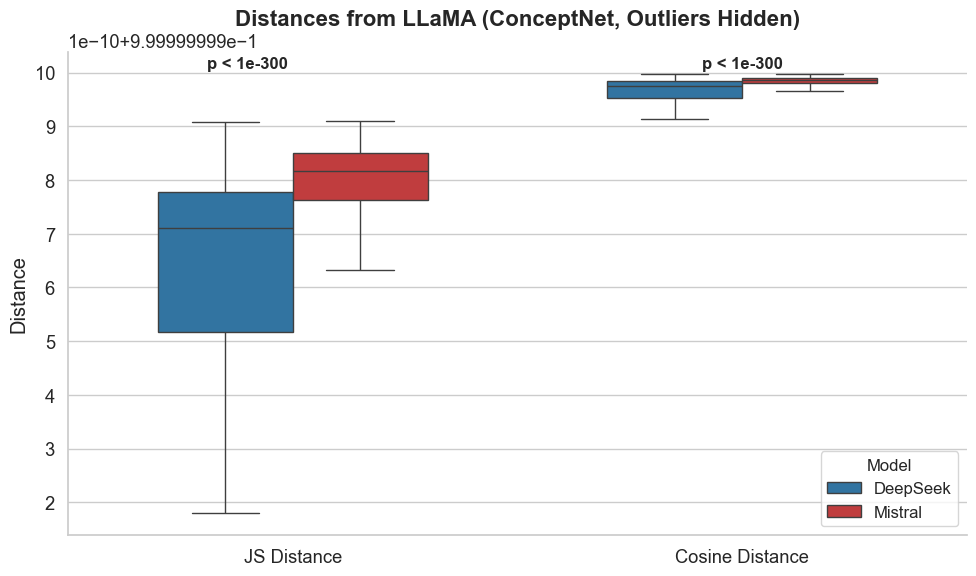

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Load ConceptNet distances
df = pd.read_csv("conceptnet_model_distances.csv")

# Prepare long-form dataframe
df_js = pd.DataFrame({
    "Distance": df["JS_distance_teacher_vs_deepseek"].tolist() +
                df["JS_distance_teacher_vs_mistral"].tolist(),
    "Model": ["DeepSeek"] * len(df) + ["Mistral"] * len(df),
    "Metric": ["JS Distance"] * (2 * len(df))
})
df_cos = pd.DataFrame({
    "Distance": df["Cosine_distance_teacher_vs_deepseek"].tolist() +
                df["Cosine_distance_teacher_vs_mistral"].tolist(),
    "Model": ["DeepSeek"] * len(df) + ["Mistral"] * len(df),
    "Metric": ["Cosine Distance"] * (2 * len(df))
})
df_plot = pd.concat([df_js, df_cos], ignore_index=True)

# Paired t-tests
p_js  = stats.ttest_rel(df["JS_distance_teacher_vs_deepseek"],
                        df["JS_distance_teacher_vs_mistral"]).pvalue
p_cos = stats.ttest_rel(df["Cosine_distance_teacher_vs_deepseek"],
                        df["Cosine_distance_teacher_vs_mistral"]).pvalue
fmt_p = lambda p: ("p < 1e-300" if p < 1e-300 else f"p = {p:.1e}")

# Plot
sns.set_theme(style="whitegrid", font_scale=1.2)
palette = {"DeepSeek": "#1f77b4", "Mistral": "#d62728"}

plt.figure(figsize=(10,6))
ax = sns.boxplot(
    data=df_plot, x="Metric", y="Distance", hue="Model",
    palette=palette, width=0.6, showfliers=False
)

# Auto y-limit from whiskers
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax)

# Annotate p-values above each metric group
ax.text(-0.1, ymax - 0.01*(ymax-ymin), fmt_p(p_js),
        ha='center', va='top', fontsize=12, fontweight='bold')
ax.text( 1.0, ymax - 0.01*(ymax-ymin), fmt_p(p_cos),
        ha='center', va='top', fontsize=12, fontweight='bold')

plt.ylabel("Distance")
plt.xlabel("")
plt.title("Distances from LLaMA (ConceptNet, Outliers Hidden)", fontsize=16, fontweight='bold')
plt.legend(title="Model", fontsize=12, title_fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()


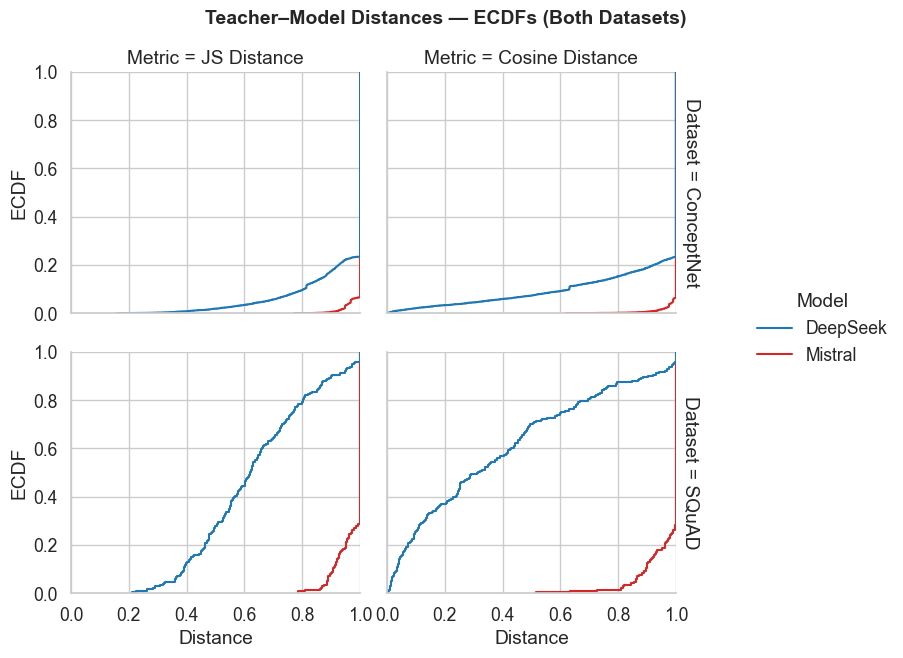

C:\Users\12822\AppData\Local\Temp\ipykernel_17776\2383269039.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g_box = sns.catplot(


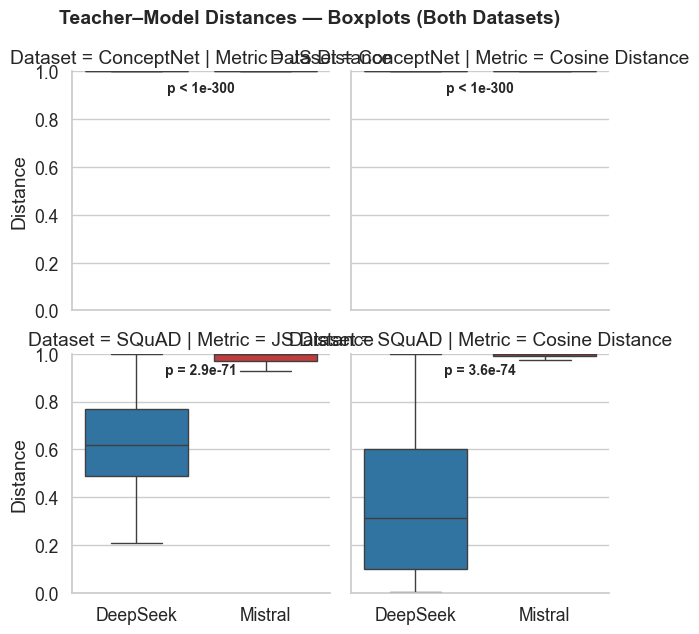

In [18]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# ---------- Load both datasets ----------
paths = {
    "ConceptNet": "conceptnet_model_distances.csv",
    "SQuAD":      "squad_model_distances.csv",
}

dfs = {}
for ds, path in paths.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        # keep the original wide columns for p-values later
        dfs[ds] = df
    else:
        print(f"[warn] Missing: {path}")

if not dfs:
    raise RuntimeError("No CSVs found. Make sure your distance CSVs exist.")

# ---------- Build long-form for plotting ----------
long_rows = []
for ds, df in dfs.items():
    # JS
    long_rows += [{
        "Dataset": ds,
        "Metric": "JS Distance",
        "Model": "DeepSeek",
        "Distance": r["JS_distance_teacher_vs_deepseek"]
    } for _, r in df.iterrows()]
    long_rows += [{
        "Dataset": ds,
        "Metric": "JS Distance",
        "Model": "Mistral",
        "Distance": r["JS_distance_teacher_vs_mistral"]
    } for _, r in df.iterrows()]
    # Cosine
    long_rows += [{
        "Dataset": ds,
        "Metric": "Cosine Distance",
        "Model": "DeepSeek",
        "Distance": r["Cosine_distance_teacher_vs_deepseek"]
    } for _, r in df.iterrows()]
    long_rows += [{
        "Dataset": ds,
        "Metric": "Cosine Distance",
        "Model": "Mistral",
        "Distance": r["Cosine_distance_teacher_vs_mistral"]
    } for _, r in df.iterrows()]

df_long = pd.DataFrame(long_rows)

# ---------- ECDFs (rows=Dataset, cols=Metric) ----------
sns.set_theme(style="whitegrid", font_scale=1.15)
palette = {"DeepSeek": "#1f77b4", "Mistral": "#d62728"}  # blue/red

g_ecdf = sns.displot(
    data=df_long, x="Distance", hue="Model", kind="ecdf",
    row="Dataset", col="Metric", hue_order=["DeepSeek", "Mistral"],
    facet_kws=dict(sharex=True, sharey=True, margin_titles=True),
    palette=palette, height=3.2, aspect=1.2
)
g_ecdf.set(xlim=(0, 1), ylim=(0, 1))
g_ecdf.set_axis_labels("Distance", "ECDF")
g_ecdf.fig.suptitle("Teacher–Model Distances — ECDFs (Both Datasets)", y=1.03, fontsize=14, fontweight="bold")
g_ecdf.savefig("both_datasets_ecdf.png", dpi=300)
plt.show()

# ---------- Boxplots (rows=Dataset, cols=Metric; x=Model) ----------
# Precompute paired t-test p-values per (Dataset, Metric)
def fmt_p(p):
    return "p < 1e-300" if p < 1e-300 else f"p = {p:.1e}"

pvals = {}
for ds, df in dfs.items():
    # Paired tests JS
    p_js = stats.ttest_rel(
        df["JS_distance_teacher_vs_deepseek"],
        df["JS_distance_teacher_vs_mistral"]
    ).pvalue
    # Paired tests Cos
    p_cos = stats.ttest_rel(
        df["Cosine_distance_teacher_vs_deepseek"],
        df["Cosine_distance_teacher_vs_mistral"]
    ).pvalue
    pvals[(ds, "JS Distance")] = p_js
    pvals[(ds, "Cosine Distance")] = p_cos

# Create the catplot grid
g_box = sns.catplot(
    data=df_long, kind="box",
    row="Dataset", col="Metric",
    x="Model", y="Distance",
    order=["DeepSeek", "Mistral"],
    showfliers=False,  # hide outliers so whiskers set the scale
    palette=[palette["DeepSeek"], palette["Mistral"]],
    height=3.2, aspect=1.0, sharey=True
)
g_box.set_axis_labels("", "Distance")
g_box.set(ylim=(0, 1))  # full 0–1 scale for honesty across datasets
g_box.fig.suptitle("Teacher–Model Distances — Boxplots (Both Datasets)", y=1.03, fontsize=14, fontweight="bold")

# Annotate p-values in each facet (center-top, axes fraction coords)
for (row_i, col_j), ax in g_box.axes_dict.items():
    # row_i is Dataset name, col_j is Metric name
    p = pvals.get((row_i, col_j), None)
    if p is not None:
        ax.text(
            0.5, 0.96, fmt_p(p),
            transform=ax.transAxes, ha="center", va="top",
            fontsize=10, fontweight="bold"
        )
    # tidy x-labels
    ax.set_xlabel("")

g_box.savefig("both_datasets_boxplots.png", dpi=300)
plt.show()
